In [1]:
import torch
import torch.nn as nn

In [2]:
class Discriminator(nn.Module):
    
    def __init__(self, channels_img, features_d):
        #features_d is just gonna be the channels that are going to change as we go through the layers of the discriminator
        
        super(Discriminator, self).__init__()
        
        self.disc = nn.Sequential(
            
            #Input : N x channels_image x 64 x 64
            nn.Conv2d(
                
                channels_img, features_d, kernel_size=4, stride=2, padding=1
                #kernel size, stride and padding are taken from the source code of DCGAN
            ), #32 x 32
            
            nn.LeakyReLU(0.2),
            
            #we are gonna skip batchnorm in first layer and last layer after the blocks - as implemented in DCGAN paper
            
            self._block(features_d, features_d*2, kernel_size=4, stride=2, padding=1), #16x16
            self._block(features_d*2, features_d*4, kernel_size=4, stride=2, padding=1), #8x8
            self._block(features_d*4, features_d*8, kernel_size=4, stride=2, padding=1), #4x4
            nn.Conv2d(features_d*8, 1, kernel_size=4, stride=2, padding= 0), #1x1 - instead of flattening it
            #Last layer has a single value to represent if its a fake image or real image. - typical img classification step in discriminator
            nn.Sigmoid(),
        
        )
        
        
        
        
    def _block(self, in_channels, out_channels, kernel_size, stride, padding):
        
        #DCGAN follows a nice structure,they have a conv layer, batch norm and leaky relu
        
        return nn.Sequential(
            
            nn.Conv2d(
                
                in_channels,
                out_channels,
                kernel_size,
                stride,
                padding,
                bias = False
                
            ),
            
            nn.BatchNorm2d(out_channels),
            nn.LeakyReLU(0.2)
            
            
        )
        
    
    def forward(self, x):
        
        return self.disc(x)
        

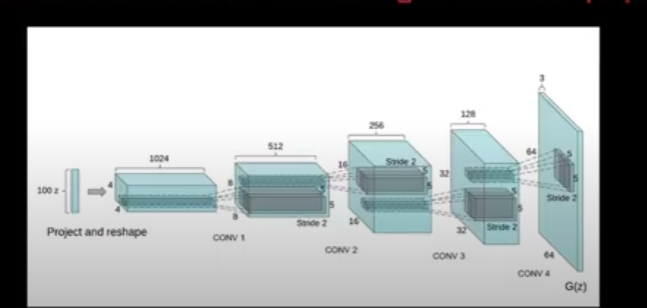

In [4]:
class Generator(nn.Module):
    
    def __init__(self, z_dim, channels_img, features_g):
        
        super(Generator,self).__init__()
        
        self.gen = nn.Sequential(
            
            #Input: N x z_dim x 1 x1 - n - batch size, z_dim x 1 x 1 is a npoise image of size 1x1 
            self._block(z_dim, features_g*16, 4, 1, 0), #N x f_g*16 x 4 x 4 - from paper, features_g = 64, so after 1st block - it will be 64*16 = 1024 feature maps of size 4x4 cuz of convtranspose in block (the block with k= 4, stride = 1 makes the image from 1x1 to 4x4)
            self._block(features_g*16, features_g*8, 4, 2, 1), #8x8, then we further reduce the features by increasing (upscaling the image) - opposite o what we do in cnn - here 512 features - 8x8 (k=4, s=2,p =1 doubles the image size - so 4x4 to 8x8) - in this paper we dont use any pooling functions, we use only convolutions to decrease or increase the space
            self._block(features_g*8, features_g*4, 4,2,1), #16x16 - 256 features 
            self._block(features_g*4 , features_g*2, 4,2,1), #32x32 - 128 features
            #for final we dont use the block because we dont wanna use batchnorm
            
            nn.ConvTranspose2d(
                
                features_g*2, channels_img, kernel_size=4, stride =2 , padding=1
            ),
            nn.Tanh(), #[-1,1] - since our images are normalized to be in [-1,1] we are making sure our model output is also in this range
            
            
        )
    
    def _block(self, in_channels, out_channels, kernel_size, stride, padding):
        
        return nn.Sequential(
            
            #conv transpose because we want to upscale the image from noise. (not typical bottle neck of cnn)
            nn.ConvTranspose2d(
                
                in_channels,
                out_channels,
                kernel_size,
                stride,
                padding,
                bias=False
                
            ),
            
            #when we are using batchnorm, we need not use bias
            nn.BatchNorm2d(out_channels),
            nn.ReLU(),
            
        )
        
    def forward(self, x):
        
        return self.gen(x)
    
    
def initialize_weights(model):
    
    for m in model.modules():
        
        if isinstance(m, (nn.Conv2d, nn.ConvTranspose2d, nn.BatchNorm2d)):
            
            nn.init.normal_(m.weight.data, 0.0, 0.02)
        #From the paper, weights of the conv layyer are initialized with a normal distribution of mean zero, std of 0.02 - typically either xavier uniform or others are followed
        

def test():
    
    N, in_channels, H, W = 8, 3, 64, 64
    z_dim = 100
    x = torch.randn((N, in_channels, H, W))
    
    disc = Discriminator(in_channels, 8) 
    initialize_weights(disc)
    assert disc(x).shape == (N,1,1,1)
    gen = Generator(z_dim, in_channels, 8)
    initialize_weights(gen)
    z = torch.randn((N, z_dim, 1, 1))
    assert gen(z).shape == (N, in_channels, H, W)
    print(' success')
    

test()
    
        

 success


In [62]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.datasets as datasets
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from torch.utils.tensorboard import SummaryWriter


In [63]:
# Hyperparameters etc.
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
LEARNING_RATE = 2e-4  # could also use two lrs, one for gen and one for disc
BATCH_SIZE = 128
IMAGE_SIZE = 64
CHANNELS_IMG = 1
Z_DIM = 100
NUM_EPOCHS = 5
FEATURES_DISC = 64
FEATURES_GEN = 64

In [64]:
transforms = transforms.Compose(
    [
        transforms.Resize((IMAGE_SIZE, IMAGE_SIZE)),
        transforms.ToTensor(),
        transforms.Normalize(
            [0.5 for _ in range(CHANNELS_IMG)] , [0.5 for _ in range(CHANNELS_IMG)]
        ),
        
        
    ]
    
)

dataset = datasets.MNIST(root = 'mnist/' , train = True, transform = transforms, download= True)

loader = DataLoader(dataset, batch_size= BATCH_SIZE, shuffle= True)

In [65]:
import matplotlib.pyplot as plt
def imshow(img):
    img = img.cpu().numpy().transpose((1, 2, 0))  # Convert from tensor image
    plt.imshow(img)
    plt.show()


Epoch [0/5] Batch 0/469                   Loss D: 0.6903, loss G: 0.7856
Epoch [0/5] Batch 100/469                   Loss D: 0.0144, loss G: 4.1203
Epoch [0/5] Batch 200/469                   Loss D: 0.2424, loss G: 1.5416
Epoch [0/5] Batch 300/469                   Loss D: 0.5164, loss G: 1.7281
Epoch [0/5] Batch 400/469                   Loss D: 0.5776, loss G: 1.2482
Epoch [1/5] Batch 0/469                   Loss D: 0.5744, loss G: 0.9919
Epoch [1/5] Batch 100/469                   Loss D: 0.5795, loss G: 0.5542
Epoch [1/5] Batch 200/469                   Loss D: 0.5961, loss G: 0.9678
Epoch [1/5] Batch 300/469                   Loss D: 0.9021, loss G: 3.0379
Epoch [1/5] Batch 400/469                   Loss D: 0.6127, loss G: 0.9406
Epoch [2/5] Batch 0/469                   Loss D: 0.6096, loss G: 0.6048
Epoch [2/5] Batch 100/469                   Loss D: 0.5086, loss G: 0.8790
Epoch [2/5] Batch 200/469                   Loss D: 0.4951, loss G: 1.1809
Epoch [2/5] Batch 300/469      

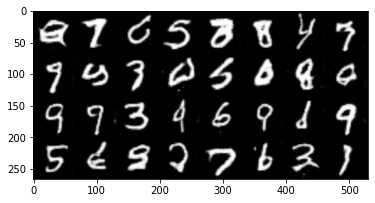

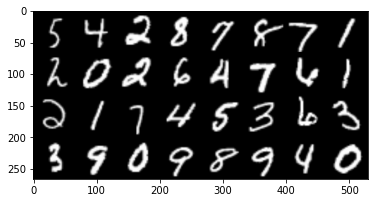

In [66]:
dataloader = DataLoader(dataset, batch_size=BATCH_SIZE, shuffle=True)
gen = Generator(Z_DIM, CHANNELS_IMG, FEATURES_GEN).to(device)
disc = Discriminator(CHANNELS_IMG, FEATURES_DISC).to(device)
initialize_weights(gen)
initialize_weights(disc)

opt_gen = optim.Adam(gen.parameters(), lr=LEARNING_RATE, betas=(0.5, 0.999))
opt_disc = optim.Adam(disc.parameters(), lr=LEARNING_RATE, betas=(0.5, 0.999))
criterion = nn.BCELoss()

fixed_noise = torch.randn(32, Z_DIM, 1, 1).to(device)
writer_real = SummaryWriter(f"logs/real_new")
writer_fake = SummaryWriter(f"logs/fake_new")
step = 0

gen.train()
disc.train()

for epoch in range(NUM_EPOCHS):
    # Target labels not needed! <3 unsupervised
    for batch_idx, (real, _) in enumerate(dataloader):
        real = real.to(device)
        noise = torch.randn(BATCH_SIZE, Z_DIM, 1, 1).to(device)
        fake = gen(noise)

        ### Train Discriminator: max log(D(x)) + log(1 - D(G(z)))
        disc_real = disc(real).reshape(-1)
        loss_disc_real = criterion(disc_real, torch.ones_like(disc_real))
        disc_fake = disc(fake.detach()).reshape(-1)
        loss_disc_fake = criterion(disc_fake, torch.zeros_like(disc_fake))
        loss_disc = (loss_disc_real + loss_disc_fake) / 2
        disc.zero_grad()
        loss_disc.backward()
        opt_disc.step()

        ### Train Generator: min log(1 - D(G(z))) <-> max log(D(G(z))
        output = disc(fake).reshape(-1)
        loss_gen = criterion(output, torch.ones_like(output))
        gen.zero_grad()
        loss_gen.backward()
        opt_gen.step()

        # Print losses occasionally and print to tensorboard
        if batch_idx % 100 == 0:
            print(
                f"Epoch [{epoch}/{NUM_EPOCHS}] Batch {batch_idx}/{len(dataloader)} \
                  Loss D: {loss_disc:.4f}, loss G: {loss_gen:.4f}"
            )

            with torch.no_grad():
                fake = gen(fixed_noise)
                # take out (up to) 32 examples
                img_grid_real = torchvision.utils.make_grid(real[:32], normalize=True)
                img_grid_fake = torchvision.utils.make_grid(fake[:32], normalize=True)

                writer_real.add_image("Real", img_grid_real, global_step=step)
                writer_fake.add_image("Fake", img_grid_fake, global_step=step)

            step += 1
    
imshow(img_grid_fake)
imshow(img_grid_real)